In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
from utils import *
from tqdm import tqdm

In [2]:
import scipy.sparse as sp
import scipy.sparse.linalg as spla

def sparse_rank_estimation(data):
    num_nodes = data.num_nodes
    edge_index = data.edge_index
    A = sp.coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])), shape=(num_nodes, num_nodes))
    D = sp.diags(A.sum(axis=1).A.flatten(), format='csr')
    L = D - A.tocsr()
    eigvals, _ = spla.eigsh(L, k=num_nodes // 2, sigma=0.0, which='SM')
    rank = np.sum(eigvals > 1e-10)
    return rank

def sparse_trace_estimation(data):
    num_nodes = data.num_nodes
    edge_index = data.edge_index
    A = sp.coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])), shape=(num_nodes, num_nodes))
    D = sp.diags(A.sum(axis=1).A.flatten(), format='csr')
    L = D - A.tocsr()
    trace = L.diagonal().sum()
    return trace

def sparse_abs_trace_estimation(data):
    num_nodes = data.num_nodes
    edge_index = data.edge_index
    A = sp.coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])), shape=(num_nodes, num_nodes))
    D = sp.diags(A.sum(axis=1).A.flatten(), format='csr')
    L = D - A.tocsr()
    trace = np.abs(L.diagonal()).sum()
    return trace

In [3]:
dataset_name_ls = ['CoraGraphDataset', 'CiteseerGraphDataset', 'PubmedGraphDataset', 'OGB_MAG']
trace_type_ls = ['Feature', 'Laplacian']
exclusion_type_ls = ['Largest', 'Smallest']
sample_rate_ls = torch.linspace(0.5, 1, 5)
trace_rst = {}

In [37]:
for dataset_name in dataset_name_ls:
    data = dataset_name2dataset(dataset_name, path='data/')
    for trace_type in trace_type_ls:
        for exclusion_type in exclusion_type_ls:
            cached_indices_path = f"SAGE_GCN/cache/{dataset_name}_{trace_type}_score_descending_indices.pt"
            sampler = Cached_Sampler(dataset_name, trace_type, exclusion_type, cached_indices_path)
            for sample_rate in sample_rate_ls:
                sampled_data = sampler.sample(data, sample_rate=sample_rate)
                print(f"Dataset: {dataset_name}, Trace Type: {trace_type}, Exclusion Type: {exclusion_type}, Sample Rate: {sample_rate}, Num Nodes: {sampled_data.num_nodes}, Edge Index Shape: {sampled_data.edge_index.shape[1]}")

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Dataset: CoraGraphDataset, Trace Type: Feature, Exclusion Type: Largest, Sample Rate: 0.5, Num Nodes: 2708, Edge Index Shape: 3358
Dataset: CoraGraphDataset, Trace Type: Feature, Exclusion Type: Largest, Sample Rate: 0.625, Num Nodes: 2708, Edge Index Shape: 1898
Dataset: CoraGraphDataset, Trace Type: Feature, Exclusion Type: Largest, Sample Rate: 0.75, Num Nodes: 2708, Edge Index Shape: 938
Dataset: CoraGraphDataset, Trace Type: Feature, Exclusion Type: Largest, Sample Rate: 0.875, Num Nodes: 2708, Edge Index Shape: 258
Dataset: CoraGraphDataset, Trace Type: Feature, Exclusion Type: Largest, Sample Rate: 1.0, Num Nodes: 2708, Edge Index Shape: 0
Dataset: CoraGraphDataset, Trace Type: Feature, Exclusion Type: Smallest, Sample Rate: 0.5, Num Nodes: 2708, Edge Index Shape: 2792
Dataset: CoraGraphDataset, Trac

In [4]:
for dataset_name in dataset_name_ls:
    data = dataset_name2dataset(dataset_name, path='data/')
    rank_ls = []
    trace_ls = []
    trace_rst[dataset_name] = {}
    for trace_type in trace_type_ls:
        trace_rst[dataset_name][trace_type] = {}
        for exclusion_type in exclusion_type_ls:
            trace_rst[dataset_name][trace_type][exclusion_type] = []
            cached_indices_path = f"SAGE_GCN/cache/{dataset_name}_{trace_type}_score_descending_indices.pt"
            sampler = Cached_Sampler(dataset_name, trace_type, exclusion_type, cached_indices_path)
            for sample_rate in sample_rate_ls:
                sampled_data = sampler.sample(data, sample_rate=sample_rate)
                # rank = sparse_rank_estimation(sampled_data)
                # rank_ls.append(rank)
                trace = sparse_trace_estimation(sampled_data)
                trace_rst[dataset_name][trace_type][exclusion_type].append(trace)


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60


In [6]:
# random sampling
random_sampler = RandomSampler()
for dataset_name in dataset_name_ls:
    data = dataset_name2dataset(dataset_name, path='data/')
    trace_rst[dataset_name]['Random'] = []
    for sample_rate in sample_rate_ls:
        sampled_data = random_sampler.sample(data, sample_rate=sample_rate)
        trace = sparse_trace_estimation(sampled_data)
        trace_rst[dataset_name]['Random'].append(trace)
        abs_trace = sparse_abs_trace_estimation(sampled_data)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


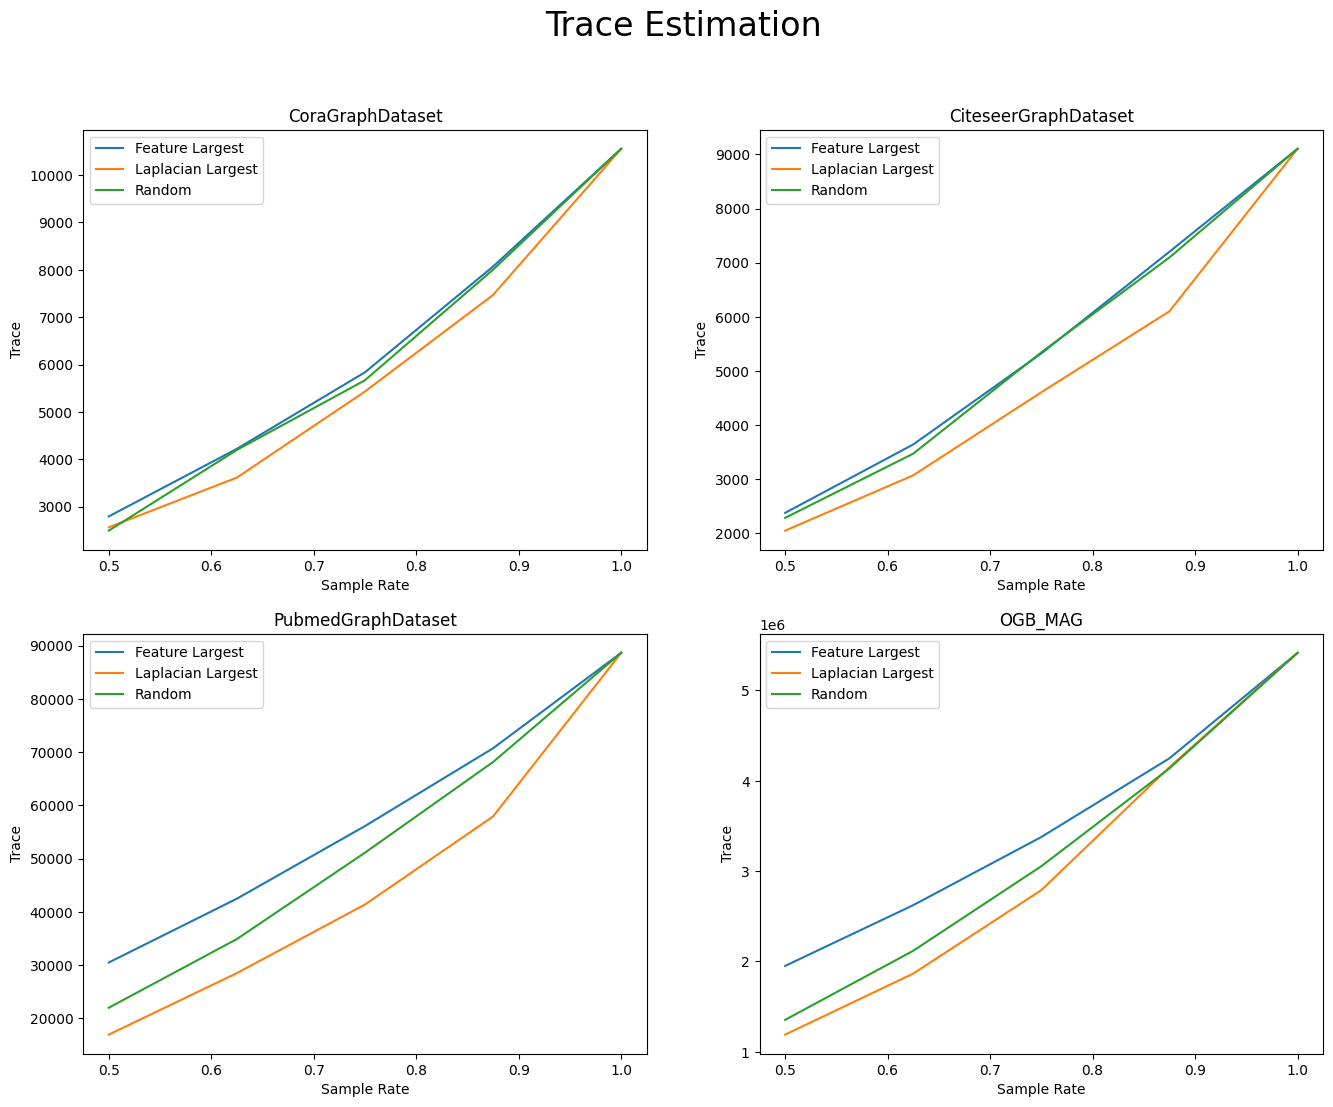

In [7]:
# plot
plt.figure(figsize=(16, 12))
for _, dataset_name in enumerate(dataset_name_ls):
    plt.subplot(2, 2, _+1)
    for trace_type in trace_type_ls:
        for exclusion_type in exclusion_type_ls:
            if exclusion_type == 'Smallest':
                continue
            plt.plot(sample_rate_ls, trace_rst[dataset_name][trace_type][exclusion_type], label=f"{trace_type} {exclusion_type}")
    plt.plot(sample_rate_ls, trace_rst[dataset_name]['Random'], label='Random')
    plt.title(dataset_name)
    plt.xlabel('Sample Rate')
    plt.ylabel('Trace')
    plt.legend()
plt.suptitle('Trace Estimation', fontsize=24)
plt.savefig("img/trace_estimation.png")

In [23]:

from torch.utils.data import DataLoader, TensorDataset
def tr_LXXT(data):
    num_nodes = data.num_nodes
    edge_index = data.edge_index
    X = data.x.numpy()
    A = sp.coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])), shape=(num_nodes, num_nodes))
    D = sp.diags(A.sum(axis=1).A.flatten(), format='csr')
    L = D - A.tocsr()
    rst_ls = np.zeros(num_nodes)
    for i in tqdm(range(num_nodes), desc='Calculating tr(LXX^T)', total=num_nodes):
        crnt_row_L = L[i]
        rst = crnt_row_L @ X
        rst = rst @ X.T[:, i]
        rst_ls[i] = rst
    trace = np.sum(rst_ls)
    return trace


def batch_tr_XXT(data):
    X = data.x
    rst = []
    loader = DataLoader(X, batch_size=1024, shuffle=False)
    for batch_X in loader:
        diag = torch.einsum('ij,ij->i', batch_X, batch_X)
        rst.extend(diag.numpy().tolist())
    return np.sum(rst)

In [24]:
trace_LXXT_rst = {}
trace_L_rst = {}
trace_XXT_rst = {}

for dataset_name in dataset_name_ls:
    data = dataset_name2dataset(dataset_name, path='data/')
    trace_L_rst[dataset_name] = {}
    trace_XXT_rst[dataset_name] = {}
    trace_LXXT_rst[dataset_name] = {}
    for trace_type in trace_type_ls:
        trace_L_rst[dataset_name][trace_type] = {}
        trace_XXT_rst[dataset_name][trace_type] = {}
        trace_LXXT_rst[dataset_name][trace_type] = {}
        for exclusion_type in exclusion_type_ls:
            trace_L_rst[dataset_name][trace_type][exclusion_type] = []
            trace_XXT_rst[dataset_name][trace_type][exclusion_type] = []
            trace_LXXT_rst[dataset_name][trace_type][exclusion_type] = []
            for sample_rate in sample_rate_ls:
                sampler = Cached_Sampler(dataset_name, trace_type, exclusion_type, f"SAGE_GCN/cache/{dataset_name}_{trace_type}_score_descending_indices.pt")
                sampled_data = sampler.sample(data, sample_rate=sample_rate)
                trace_L = sparse_trace_estimation(sampled_data)
                trace_L_rst[dataset_name][trace_type][exclusion_type].append(trace_L ** 2)
                trace_XXT = batch_tr_XXT(sampled_data)
                trace_XXT_rst[dataset_name][trace_type][exclusion_type].append(trace_XXT ** 2)
                trace_LXXT = tr_LXXT(sampled_data)
                trace_LXXT_rst[dataset_name][trace_type][exclusion_type].append(trace_LXXT ** 2)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Calculating tr(LXX^T):   0%|          | 0/2708 [00:00<?, ?it/s]/tmp/ipykernel_1581091/1291907211.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rst_ls[i] = rst
Calculating tr(LXX^T): 100%|██████████| 2708/2708 [00:03<00:00, 703.12it/s]


  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Calculating tr(LXX^T): 100%|██████████| 3327/3327 [00:38<00:00, 87.15it/s]


  NumNodes: 19717
  NumEdges: 88651
  NumFeats: 500
  NumClasses: 3
  NumTrainingSamples: 60
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


Calculating tr(LXX^T):   4%|▍         | 30908/736389 [1:40:37<38:16:50,  5.12it/s] 


KeyboardInterrupt: 

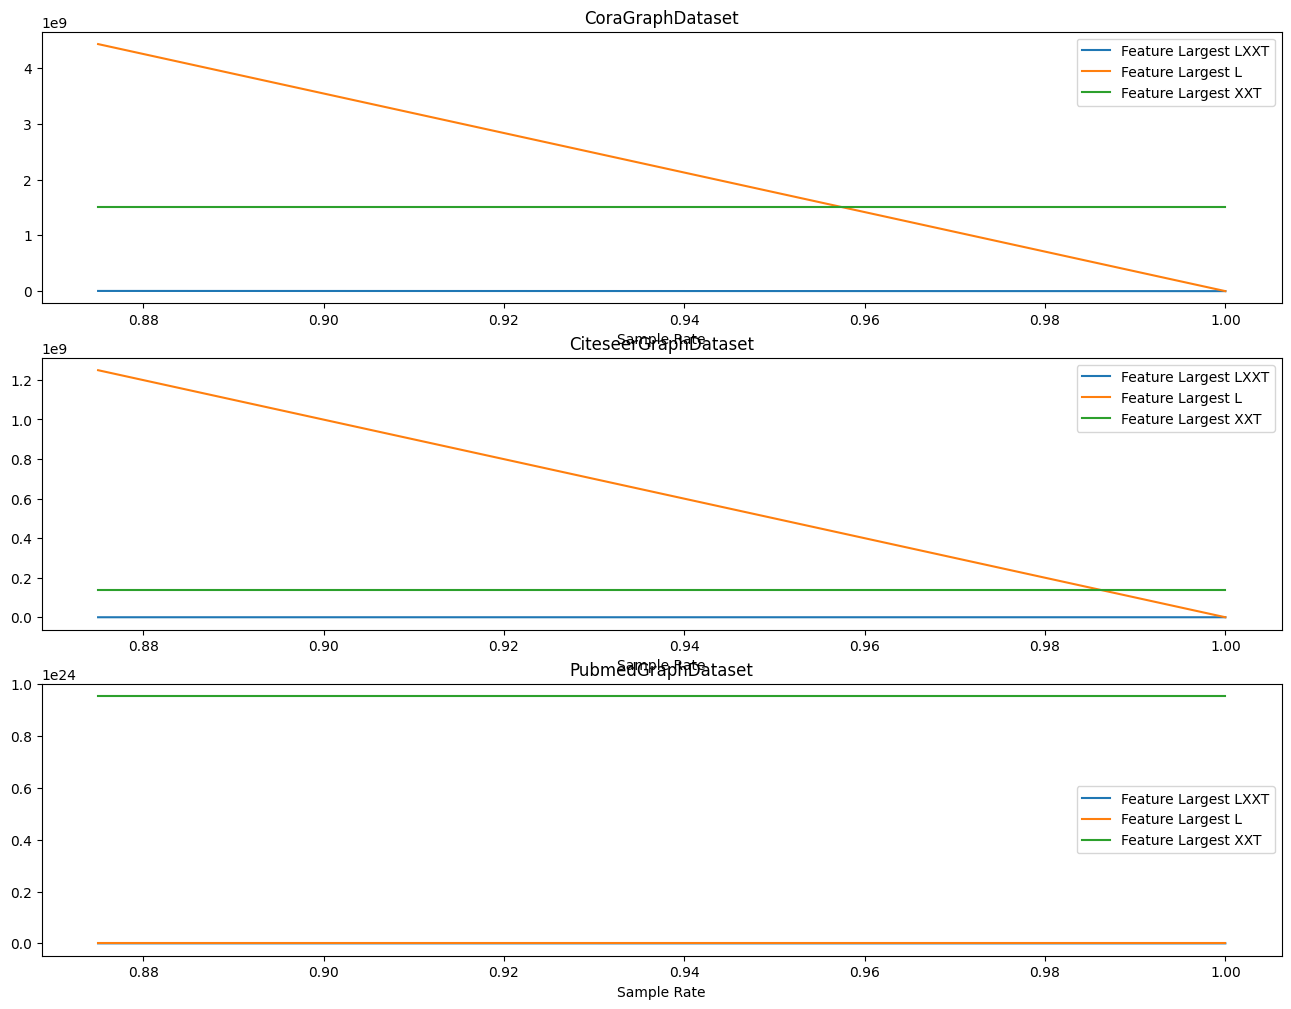

In [33]:
plt.figure(figsize=(16, 12))
for _, dataset_name in enumerate(dataset_name_ls[:-1]):
    plt.subplot(3, 1, _+1)
    for trace_type in trace_type_ls:
        for exclusion_type in exclusion_type_ls:
            if exclusion_type == 'Smallest':
                continue
            if trace_type == 'Laplacian':
                continue
            L = trace_L_rst[dataset_name][trace_type][exclusion_type]
            XXT = trace_XXT_rst[dataset_name][trace_type][exclusion_type]
            LXXT = trace_LXXT_rst[dataset_name][trace_type][exclusion_type]
            # plt.plot(sample_rate_ls[3:], (np.array(L) ** 2 * np.array(XXT) ** 2)[3:], label=f"{trace_type} {exclusion_type} L * XXT")
            plt.plot(sample_rate_ls[3:], (np.array(LXXT) ** 2)[3:], label=f"{trace_type} {exclusion_type} LXXT")
            plt.plot(sample_rate_ls[3:], (np.array(L) ** 2)[3:], label=f"{trace_type} {exclusion_type} L")
            plt.plot(sample_rate_ls[3:], (np.array(XXT) ** 2)[3:], label=f"{trace_type} {exclusion_type} XXT")
    plt.title(dataset_name)
    plt.xlabel('Sample Rate')
    plt.legend()